# Debug Notebook for GitHub Copilot Usage

This notebook demonstrates how to instantiate and invoke methods from your local exporter scripts. You can use it to debug the data extraction and adaptation processes for GitHub Copilot usage data.

In [10]:
# If your project structure is something like:
# PROJECT_ROOT/
#   |-- notebooks/debug_copilot_usage.ipynb
#   |-- src/
#        |-- extractor/
#             |-- github_exporter.py
#             |-- github_copilot_exporter.py
#        |-- common/
#             |-- common.py
#        |-- ...
# make sure to add the project root to sys.path if needed.

import sys
import os
project_root = os.path.abspath(os.path.join('..'))  # Adjust path if needed
if project_root not in sys.path:
    sys.path.append(project_root)

# Now we can import our local modules:


## Prepare a Configuration Dictionary
Below is a sample configuration dictionary. Adjust the values according to your project’s needs or how you manage configs (e.g., from a .ini or .env file).

In [ ]:

from src.extractor.github_copilot_exporter import GithubCopilotExporter
from src.transformer.copilot_transformer import CopilotTransformer
from src.loader.csv_loader import CsvLoader

import pandas as pd

pd.options.mode.chained_assignment = None

config = {
    "GITHUB": {
        "github_url": "https://api.github.com",
        "github_org": "gologic-partner",     # Replace with your organization
        "github_token": ""
    }   
}

# Instantiate the Exporter
copilot_exporter = GithubCopilotExporter()
copilot_exporter.initialize_data(config)

copilot_transformer = CopilotTransformer()
copilot_transformer.initialize_data(config)

csv_loader = CsvLoader()
csv_loader.initialize_data({
    "CSV": {
        "csv_filename_prefix": "copilot"  # This will create files like copilot_metrics_chat_global.csv
    }
})

## Call the Copilot Usage Endpoint
We’ll do a simple request to GitHub’s Copilot usage endpoint. Adjust the query parameters (e.g., since, until) as needed.

For reference, see: [Copilot Usage Docs](https://docs.github.com/en/rest/copilot/copilot-usage?apiVersion=2022-11-28).

In [12]:
# Cell 2 - Code
# First get the teams
teams = copilot_exporter.extract_teams()
print("\nTeams found:")
for team in teams:
    print(f"- {team['name']} (slug: {team['slug']})")


Teams found:
- Équipe développement 1 (slug: equipe-developpement-1)
- Équipe GitHub (slug: equipe-github)
- go-squad (slug: go-squad)


In [13]:
# Cell 3 - Code
# Get metrics for each team
metrics_per_team = copilot_exporter.extract_metrics_per_team(teams)
metrics_per_team


2025-04-24 15:10:06,193 - src.extractor.github_copilot_exporter - WARNING - No Copilot metrics found for team go-squad


{'equipe-developpement-1': [{'date': '2025-03-28',
   'copilot_ide_chat': {'editors': [{'name': 'vscode',
      'models': [{'name': 'default',
        'total_chats': 2,
        'is_custom_model': False,
        'total_engaged_users': 1,
        'total_chat_copy_events': 0,
        'total_chat_insertion_events': 0}],
      'total_engaged_users': 1}],
    'total_engaged_users': 1},
   'total_active_users': 2,
   'copilot_dotcom_chat': {'total_engaged_users': 0},
   'total_engaged_users': 2,
   'copilot_dotcom_pull_requests': {'total_engaged_users': 0},
   'copilot_ide_code_completions': {'editors': [{'name': 'JetBrains',
      'models': [{'name': 'default',
        'languages': [{'name': 'csharp',
          'total_engaged_users': 1,
          'total_code_acceptances': 9,
          'total_code_suggestions': 54,
          'total_code_lines_accepted': 10,
          'total_code_lines_suggested': 149}],
        'is_custom_model': False,
        'total_engaged_users': 1}],
      'total_engaged

In [14]:
adapted_metrics_chat_per_team = copilot_exporter.adapt_metrics_chat_team(metrics_per_team)
adapted_metrics_chat_per_team

,team,date,editor_name,model_name,total_engaged_users,total_chat,total_chat_insertion_events,total_chat_copy_events
0,equipe-developpement-1,2025-03-28,vscode,default,1,2,0,0
1,equipe-developpement-1,2025-03-31,JetBrains,default,2,7,0,0
2,equipe-developpement-1,2025-04-01,JetBrains,default,1,3,2,1
3,equipe-developpement-1,2025-04-02,JetBrains,default,1,2,1,2
4,equipe-developpement-1,2025-04-03,vscode,default,2,12,0,1
...,...,...,...,...,...,...,...,...
60,equipe-github,2025-04-21,vscode,default,2,68,0,13
61,equipe-github,2025-04-22,JetBrains,default,2,6,8,10
62,equipe-github,2025-04-22,vscode,default,4,176,0,10
63,equipe-github,2025-04-23,vscode,default,4,162,1,16


In [15]:
adapted_metrics_completition_per_team = copilot_exporter.adapt_metrics_completions_team(metrics_per_team)
adapted_metrics_completition_per_team

,team,date,editor_name,model_name,language,total_code_lines_suggested,total_code_lines_accepted,total_engaged_users
0,equipe-developpement-1,2025-03-28,JetBrains,default,csharp,149,10,1
1,equipe-developpement-1,2025-03-28,vscode,default,typescriptreact,1,0,0
2,equipe-developpement-1,2025-03-31,JetBrains,default,csharp,572,162,3
3,equipe-developpement-1,2025-03-31,JetBrains,default,java,131,38,3
4,equipe-developpement-1,2025-04-01,JetBrains,default,ini,5,0,2
...,...,...,...,...,...,...,...,...
203,equipe-github,2025-04-23,vscode,default,python,1,0,1
204,equipe-github,2025-04-23,JetBrains,default,java,151,33,3
205,equipe-github,2025-04-23,JetBrains,default,csharp,9,4,3
206,equipe-github,2025-04-23,JetBrains,default,markdown,1,1,3


In [16]:
global_metrics = copilot_exporter.extract_metrics_global()
global_metrics

[{'date': '2025-03-28',
  'copilot_ide_chat': {'editors': [{'name': 'vscode',
     'models': [{'name': 'default',
       'total_chats': 13,
       'is_custom_model': False,
       'total_engaged_users': 3,
       'total_chat_copy_events': 0,
       'total_chat_insertion_events': 0}],
     'total_engaged_users': 3},
    {'name': 'JetBrains',
     'models': [{'name': 'default',
       'total_chats': 1,
       'is_custom_model': False,
       'total_engaged_users': 1,
       'total_chat_copy_events': 0,
       'total_chat_insertion_events': 0}],
     'total_engaged_users': 1}],
   'total_engaged_users': 3},
  'total_active_users': 6,
  'copilot_dotcom_chat': {'total_engaged_users': 0},
  'total_engaged_users': 4,
  'copilot_dotcom_pull_requests': {'total_engaged_users': 0},
  'copilot_ide_code_completions': {'editors': [{'name': 'JetBrains',
     'models': [{'name': 'default',
       'languages': [{'name': 'java',
         'total_engaged_users': 0,
         'total_code_acceptances': 0,
  

In [17]:
billing_global = copilot_exporter.extract_billing()
billing_global

{'billing_information': {'seat_breakdown': {'pending_invitation': 0,
   'pending_cancellation': 0,
   'added_this_cycle': 1,
   'total': 19,
   'active_this_cycle': 17,
   'inactive_this_cycle': 2},
  'seat_management_setting': 'assign_selected',
  'plan_type': 'enterprise',
  'public_code_suggestions': 'allow',
  'ide_chat': 'enabled',
  'cli': 'enabled',
  'platform_chat': 'enabled'}}

In [18]:
# Create a DataFrame from the global metrics data and normalize nested JSON
import pandas as pd
import json
from pandas import json_normalize

# First flatten the nested copilot_ide_chat structure
flattened_metrics = []
for metric in global_metrics:
    # Get base fields
    flat_metric = {
        'date': metric['date']
    }
    
    # Extract editor metrics
    for editor in metric['copilot_ide_chat']['editors']:
        for model in editor['models']:
            # Add editor and model info
            record = flat_metric.copy()
            record.update({
                'editor_name': editor['name'],
                'model_name': model['name'],
                'total_engaged_users': model.get('total_engaged_users', 0),
                'total_chats': model.get('total_chats', 0)
            })
            
            # Add language-specific metrics if present
            if 'languages' in model:
                for lang in model['languages']:
                    lang_record = record.copy()
                    lang_record.update({
                        'language': lang['name'],
                        'language_engaged_users': lang.get('total_engaged_users', 0)
                    })
                    flattened_metrics.append(lang_record)
            else:
                flattened_metrics.append(record)

# Create normalized DataFrame
df_global_metrics = pd.DataFrame(flattened_metrics)
display(df_global_metrics)


,date,editor_name,model_name,total_engaged_users,total_chats
0,2025-03-28,vscode,default,3,13
1,2025-03-28,JetBrains,default,1,1
2,2025-03-29,vscode,default,1,18
3,2025-03-30,vscode,default,1,4
4,2025-03-31,JetBrains,default,5,19
5,2025-03-31,vscode,default,3,30
6,2025-04-01,JetBrains,default,3,7
7,2025-04-01,vscode,default,3,88
8,2025-04-02,JetBrains,default,4,7
9,2025-04-02,vscode,default,4,91


In [19]:
adapted_active_user_metrics = copilot_exporter.adapt_metrics_active_users(global_metrics)
adapted_active_user_metrics

,date,total_active_users,total_engaged_users
0,2025-03-28,6,4
1,2025-03-29,1,1
2,2025-03-30,1,1
3,2025-03-31,9,9
4,2025-04-01,8,7
5,2025-04-02,10,9
6,2025-04-03,11,10
7,2025-04-04,8,8
8,2025-04-05,2,2
9,2025-04-06,1,1


In [20]:
adapted_billing_global = copilot_exporter.adapt_billing_global(billing_global)
adapted_billing_global

,extract_date,total,added_this_cycle,active_this_cycle,inactive_this_cycle
0,2025-04-24,19,1,17,2


In [21]:
adapted_global_metrics = copilot_exporter.adapt_metrics_chat_global(global_metrics)
adapted_global_metrics


,team,date,editor_name,model_name,total_engaged_users,total_chat,total_chat_insertion_events,total_chat_copy_events
0,None,2025-03-28,vscode,default,3,13,0,0
1,None,2025-03-28,JetBrains,default,1,1,0,0
2,None,2025-03-29,vscode,default,1,18,0,1
3,None,2025-03-30,vscode,default,1,4,0,0
4,None,2025-03-31,JetBrains,default,5,19,1,1
5,None,2025-03-31,vscode,default,3,30,0,5
6,None,2025-04-01,JetBrains,default,3,7,8,8
7,None,2025-04-01,vscode,default,3,88,0,16
8,None,2025-04-02,JetBrains,default,4,7,1,4
9,None,2025-04-02,vscode,default,4,91,0,76


In [22]:
adapted_metrics_completion_global = copilot_exporter.adapt_metrics_completions_global(global_metrics)
adapted_metrics_completion_global


,team,date,editor_name,model_name,language,total_code_lines_suggested,total_code_lines_accepted,total_engaged_users
0,None,2025-03-28,JetBrains,default,java,177,0,2
1,None,2025-03-28,JetBrains,default,csharp,257,20,2
2,None,2025-03-28,JetBrains,default,html,1,0,2
3,None,2025-03-28,vscode,default,python,144,22,1
4,None,2025-03-28,vscode,default,shellscript,6,0,1
...,...,...,...,...,...,...,...,...
209,None,2025-04-23,vscode,default,python,1,0,2
210,None,2025-04-23,JetBrains,default,java,316,50,5
211,None,2025-04-23,JetBrains,default,csharp,994,103,5
212,None,2025-04-23,JetBrains,default,markdown,1,1,5


In [23]:
# no transformation to apply on active users currently
transformed_metrics_active_users = adapted_active_user_metrics

In [24]:
transformed_metrics_average_active_users = copilot_transformer.transform_average_active_users(transformed_metrics_active_users['total_active_users'])
transformed_metrics_average_active_users

,extract_date,average_active_users
0,2025-04-24,7


In [25]:
# no transformation to apply on billing information
transformed_metrics_billing_global = adapted_billing_global

In [26]:
transformed_metrics_chat = copilot_transformer.transform_chat_metrics_team(adapted_metrics_chat_per_team)
print("Transformed Chat Metrics per Team:")
display(transformed_metrics_chat)

Transformed Chat Metrics per Team:


,team,date,total_chat,total_engaged_users,total_chat_copy_events,total_chat_insertion_events,chat_per_user,chat_acceptance_rate
0,equipe-developpement-1,2025-03-28,2,1,0,0,2.000000,0.000000
1,equipe-developpement-1,2025-03-31,7,2,0,0,3.500000,0.000000
2,equipe-developpement-1,2025-04-01,3,1,1,2,3.000000,1.000000
3,equipe-developpement-1,2025-04-02,2,1,2,1,2.000000,1.500000
4,equipe-developpement-1,2025-04-03,13,3,1,0,4.333333,0.076923
5,equipe-developpement-1,2025-04-04,5,2,0,0,2.500000,0.000000
6,equipe-developpement-1,2025-04-07,7,2,7,7,3.500000,2.000000
7,equipe-developpement-1,2025-04-08,10,1,4,0,10.000000,0.400000
8,equipe-developpement-1,2025-04-09,11,3,3,0,3.666667,0.272727
9,equipe-developpement-1,2025-04-10,23,2,0,0,11.500000,0.000000


In [27]:
transformed_completion_metrics = copilot_transformer.transform_completion_metrics_team(adapted_metrics_completition_per_team)
print("Transformed Completion Metrics per Team:")
display(transformed_completion_metrics)


Transformed Completion Metrics per Team:


,team,date,language,total_code_lines_accepted,total_code_lines_suggested,completion_acceptance_rate
0,equipe-developpement-1,2025-03-28,csharp,10,149,0.067114
1,equipe-developpement-1,2025-03-28,typescriptreact,0,1,0.000000
2,equipe-developpement-1,2025-03-31,csharp,162,572,0.283217
3,equipe-developpement-1,2025-03-31,java,38,131,0.290076
4,equipe-developpement-1,2025-04-01,csharp,98,897,0.109253
...,...,...,...,...,...,...
188,equipe-github,2025-04-23,ruby,0,2,0.000000
189,equipe-github,2025-04-23,shellscript,1,13,0.076923
190,equipe-github,2025-04-23,sql,0,3,0.000000
191,equipe-github,2025-04-23,xml,0,7,0.000000


In [28]:
transformed_global_chat = copilot_transformer.transform_chat_metrics_global(adapted_global_metrics)
print("Transformed Global Chat Metrics:")
display(transformed_global_chat)

Transformed Global Chat Metrics:


,date,total_chat,total_engaged_users,total_chat_copy_events,total_chat_insertion_events,chat_per_user,chat_acceptance_rate
0,2025-03-28,14,4,0,0,3.500000,0.000000
1,2025-03-29,18,1,1,0,18.000000,0.055556
2,2025-03-30,4,1,0,0,4.000000,0.000000
3,2025-03-31,49,8,6,1,6.125000,0.142857
4,2025-04-01,95,6,24,8,15.833333,0.336842
5,2025-04-02,98,8,80,1,12.250000,0.826531
6,2025-04-03,229,8,29,0,28.625000,0.126638
7,2025-04-04,130,7,12,5,18.571429,0.130769
8,2025-04-05,4,1,1,0,4.000000,0.250000
9,2025-04-06,2,1,0,0,2.000000,0.000000


In [29]:
transformed_global_completion = copilot_transformer.transform_completion_metrics_global(adapted_metrics_completion_global)
print("Transformed Global Completion Metrics:")
display(transformed_global_completion)

Transformed Global Completion Metrics:


,date,language,total_code_lines_accepted,total_code_lines_suggested,completion_acceptance_rate
0,2025-03-28,csharp,20,257,0.077821
1,2025-03-28,html,0,1,0.000000
2,2025-03-28,java,0,177,0.000000
3,2025-03-28,python,22,144,0.152778
4,2025-03-28,shellscript,0,6,0.000000
...,...,...,...,...,...
191,2025-04-23,shellscript,1,13,0.076923
192,2025-04-23,sql,0,3,0.000000
193,2025-04-23,terraform,0,13,0.000000
194,2025-04-23,xml,0,7,0.000000


In [30]:
transformed_data = {
    "metrics_active_users" : transformed_metrics_active_users,
    "metrics_average_active_users" : transformed_metrics_average_active_users,
    "metrics_billing_global" : transformed_metrics_billing_global,
    "metrics_chat_global": transformed_global_chat,
    "metrics_chat_team": transformed_metrics_chat,
    "metrics_completion_global": transformed_global_completion,
    "metrics_completion_team": transformed_completion_metrics
}

csv_loader.load_data(transformed_data)

CSV file copilot_metrics_active_users.csv created
CSV file copilot_metrics_average_active_users.csv created
CSV file copilot_metrics_billing_global.csv created
CSV file copilot_metrics_chat_global.csv created
CSV file copilot_metrics_chat_team.csv created
CSV file copilot_metrics_completion_global.csv created
CSV file copilot_metrics_completion_team.csv created


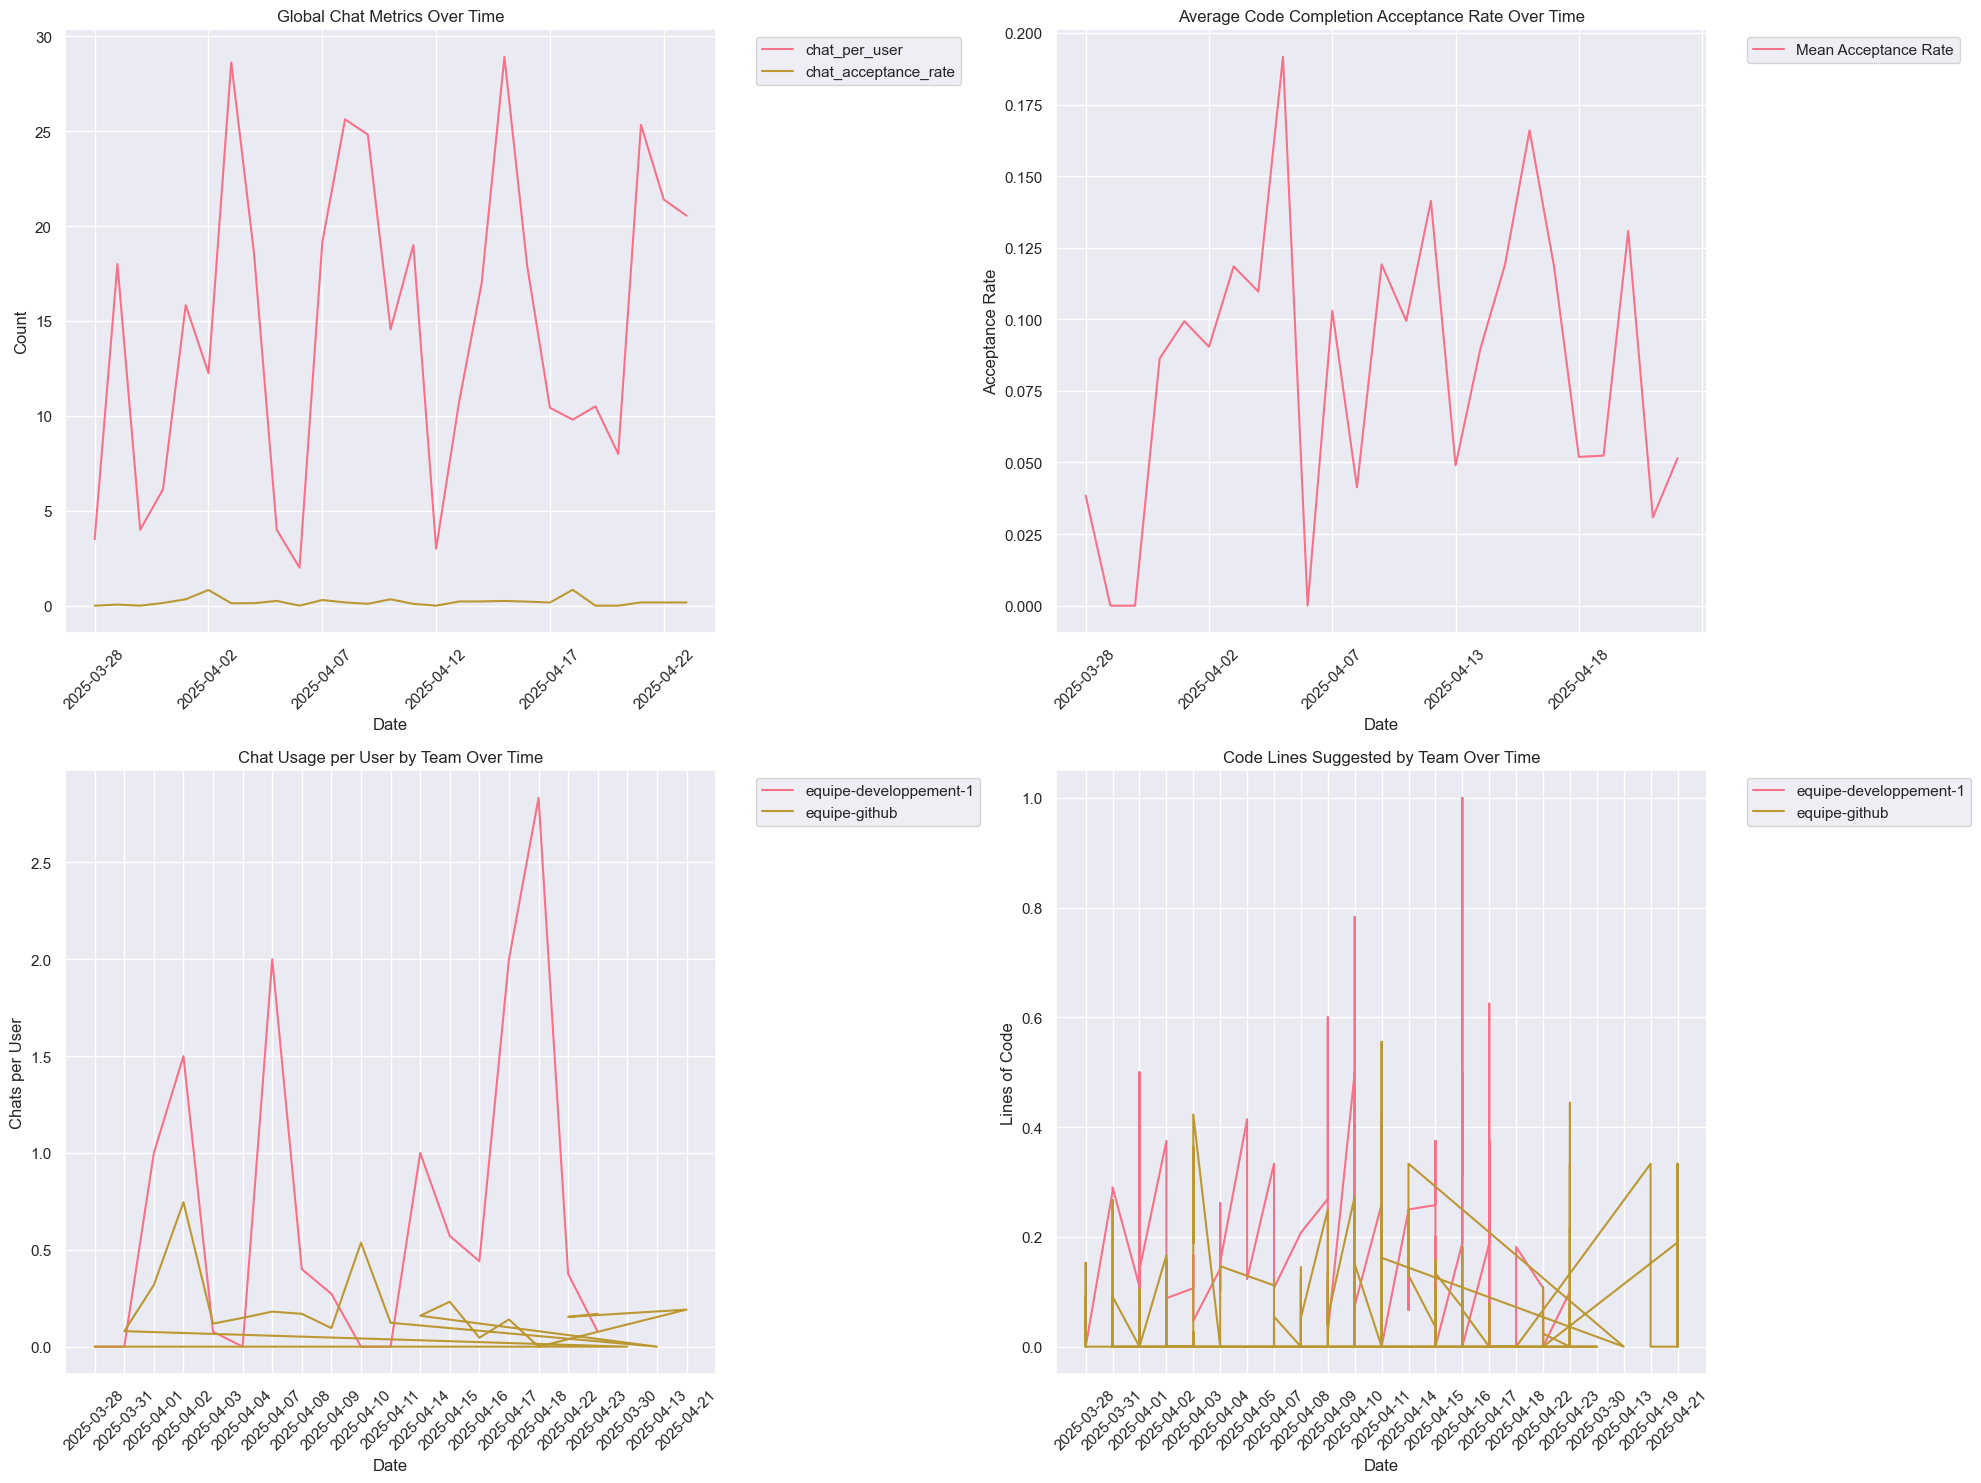

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the style
sns.set_theme()
sns.set_palette("husl")

# Create a figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Plot 1: Global Chat Metrics Over Time
transformed_global_chat.plot(x='date', y=['chat_per_user', 'chat_acceptance_rate'], ax=ax1)
ax1.set_title('Global Chat Metrics Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Global Completion Metrics Over Time
mean_acceptance = transformed_global_completion.groupby('date')['completion_acceptance_rate'].mean()
mean_acceptance.plot(ax=ax2)
ax2.set_title('Average Code Completion Acceptance Rate Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Acceptance Rate')
ax2.legend(['Mean Acceptance Rate'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Chat Metrics by Team Over Time
lines = []
for team in transformed_metrics_chat['team'].unique():
    team_data = transformed_metrics_chat[transformed_metrics_chat['team'] == team]
    line, = ax3.plot(team_data['date'], team_data['chat_acceptance_rate'], label=team)
    lines.append(line)
ax3.set_title('Chat Usage per User by Team Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Chats per User')
ax3.legend(handles=lines, bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Code Completion by Team Over Time
lines = []
for team in transformed_completion_metrics['team'].unique():
    team_data = transformed_completion_metrics[transformed_completion_metrics['team'] == team]
    line, = ax4.plot(team_data['date'], team_data['completion_acceptance_rate'], label=team)
    lines.append(line)
ax4.set_title('Code Lines Suggested by Team Over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('Lines of Code')
ax4.legend(handles=lines, bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Placeholder export and transform for active users, average active users, inactive seats and added seats this billing period

TODO: refactor with mappings.json to use the global_metrics. rework adapt and transform consequently

In [32]:
daily_active_users = copilot_exporter.extract_daily_active_users()
new_seats_added, inactive_users = copilot_exporter.extract_seats_information()

df_daily_active_users = copilot_exporter.adapt_daily_active_users(daily_active_users)
df_seats = copilot_exporter.adapt_seats_information(new_seats_added, inactive_users)

adapted_data = {
    "df_daily_active_users": df_daily_active_users,
    "df_seats": df_seats
}

transformed_data = copilot_transformer.transform_data(adapted_data)
# load csv

AttributeError: 'GithubCopilotExporter' object has no attribute 'extract_daily_active_users'

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

def create_charts(transformed_data):
    # Create figure for daily active users
    fig, ax = plt.subplots(figsize=(12, 6))
    df_daily = transformed_data['df_daily_active_users']
    
    # Use dates directly without conversion since they're already timestamps
    ax.plot(df_daily['date'], df_daily['active_users'], marker='o', linestyle='-', linewidth=2)
    ax.set_title('Daily Active Users Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Active Users')
    ax.grid(True)
    
    # Format x-axis dates
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('daily_active_users.png')
    plt.show()

    # 2. Average Active Users
    fig, ax = plt.subplots(figsize=(6, 4))
    avg_users = transformed_data['df_average_active_users']['average_active_users'].iloc[0]
    ax.bar(['Average'], [avg_users], color='skyblue')
    ax.set_title('Average Active Users')
    ax.set_ylabel('Number of Users')
    plt.tight_layout()
    plt.savefig('average_active_users.png')
    plt.show()

    # 3. Seats Distribution
    fig, ax = plt.subplots(figsize=(8, 5))
    seats_data = transformed_data['df_seats']
    labels = ['Seats']
    added = seats_data['added_seats']
    inactive = seats_data['inactive_seats']
    
    ax.bar(labels, added, label='Added Seats', color='lightgreen')
    ax.bar(labels, inactive, bottom=added, label='Inactive Seats', color='lightcoral')
    ax.set_title('Seats Distribution')
    ax.set_ylabel('Number of Seats')
    ax.legend()
    plt.tight_layout()
    plt.savefig('seats_distribution.png')
    plt.show()

# Call the function
create_charts(transformed_data)

In [ ]:
import requests

# Remplacez par votre token GitHub (avec les permissions adéquates)
GITHUB_TOKEN = ""
# Remplacez par le login de l'organisation à interroger
ORG_NAME = ""

url = "https://api.github.com/graphql"

query = """
query($org: String!) {
  organization(login: $org) {
    membersWithRole(first: 100) {
      nodes {
        login
        email
      }
    }
  }
}
"""

variables = {"org": ORG_NAME}

headers = {
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "Content-Type": "application/json"
}

response = requests.post(url, json={"query": query, "variables": variables}, headers=headers)

if response.status_code == 200:
    data = response.json()
    members = data.get("data", {}).get("organization", {}).get("membersWithRole", {}).get("nodes", [])
    members_list = []
    for member in members:
        members_list.append({
            "login": member['login'],
            "email": member['email'],
            
        })
    print(f"Found {len(members_list)} members:")
    print(members_list)
else:
    print("Erreur :", response.status_code, response.text)

## Conclusion
You can now inspect these DataFrames, observe schema changes, and debug any issues with your transformation logic or with the GitHub API data itself. Use additional cells as needed to explore data, handle errors, etc.